# next
* fix all tests
* simulate brain below with and without hebbian learning AND der
* create a ground neuron that is always on (this is needed to create a NAND)
* directly create a NAND (maybe make a nand classmethod constructor)
* see if you can converge to a NAND given an initial topology that works
* do all synapses need to have the possibility of being both inhibitory and excitatory? what then?

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50,50]

import brain; import importlib; importlib.reload(brain);

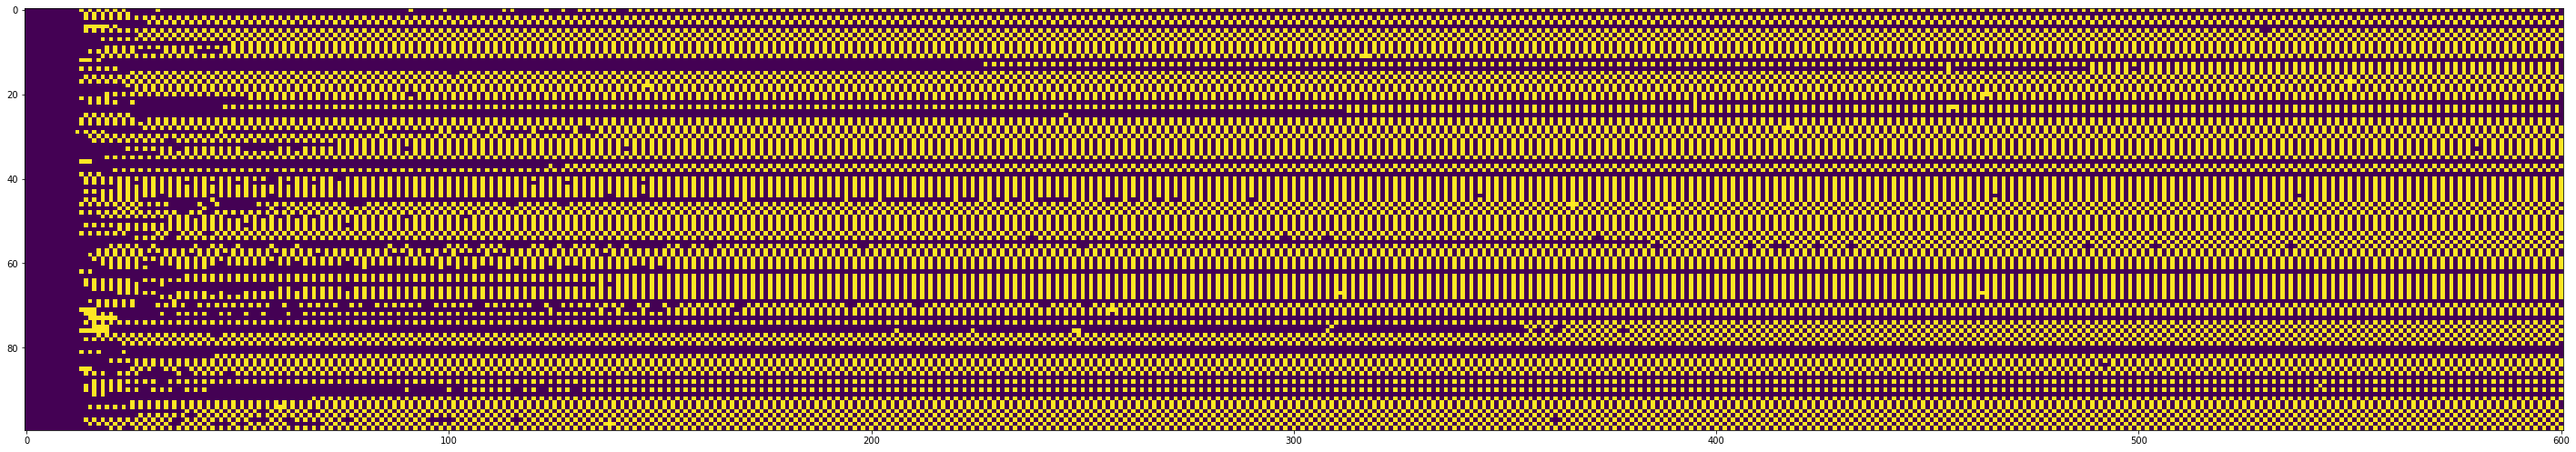

In [47]:
b = brain.Brain(
    num_neurons=100, 
    excitatory_synaptic_density=0.2,
    inhibitory_synaptic_density=0.4,
    neuronal_threshold=1,
    probability_of_random_excitation=0.001,
    initial_active_neuron_density=0.5,
)
b.simulate_brain(
    600,
    with_hebbian_learning=True,
)

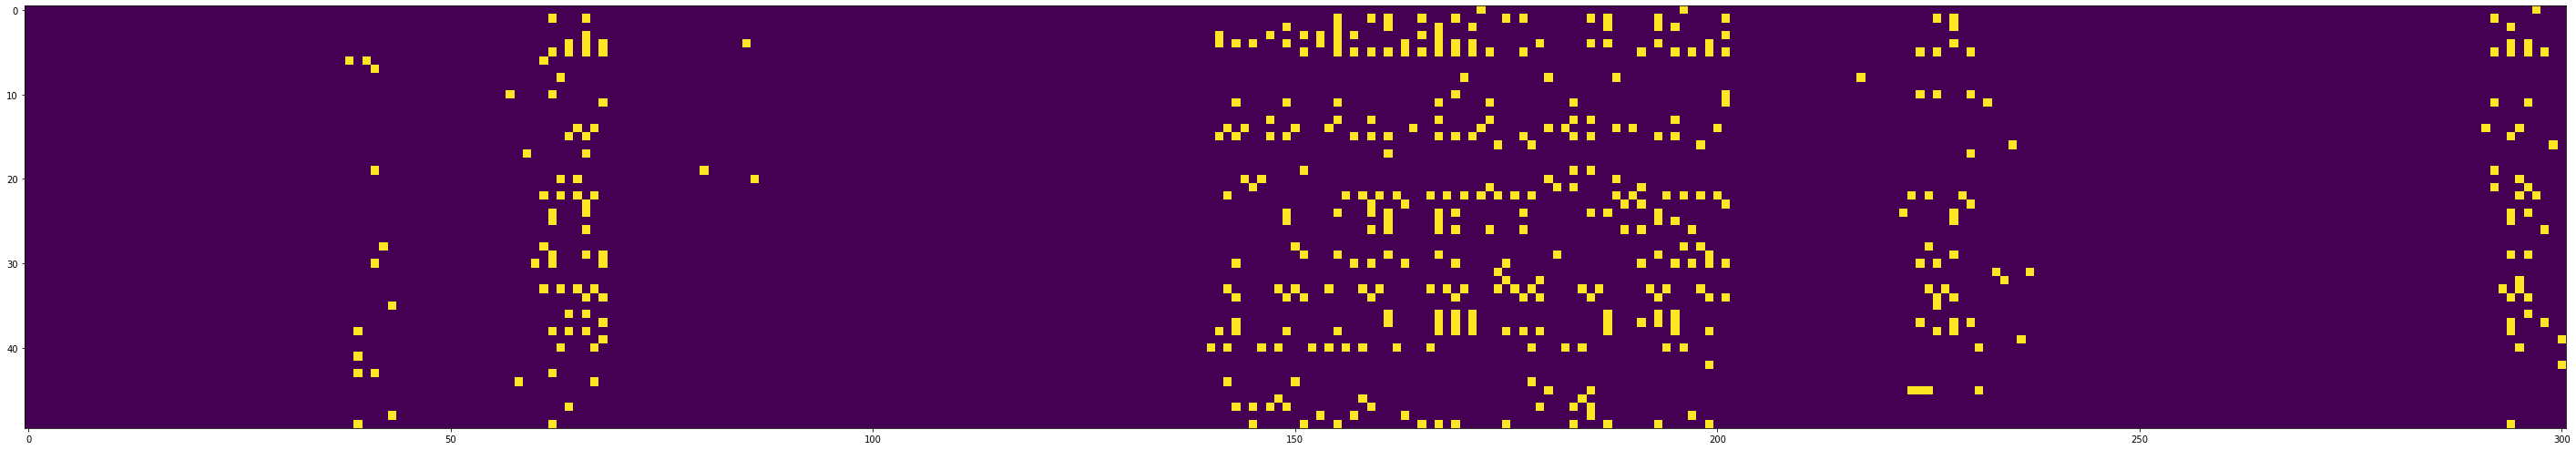

In [139]:
b.simulate_brain(
    300,
    with_hebbian_learning=True,
)

In [639]:
(b.synapses_a / (b.synapses_a + b.synapses_b))

<ipython-input-639-f662ffe867c0>:1: RuntimeWarning: invalid value encountered in true_divide
  (b.synapses_a / (b.synapses_a + b.synapses_b))


array([[0.00184502,        nan, 0.0202952 , ...,        nan, 0.03874539,
               nan],
       [0.00177936, 0.01957295,        nan, ..., 0.00177936,        nan,
               nan],
       [0.99818841, 0.01992754, 0.01992754, ..., 0.00181159, 0.01992754,
        0.00181159],
       ...,
       [0.00181159,        nan, 0.01992754, ..., 0.99818841, 0.05615942,
        0.00181159],
       [0.00181159, 0.03804348, 0.01992754, ..., 0.00181159, 0.99818841,
               nan],
       [0.00181159, 0.98007246, 0.01992754, ...,        nan, 0.05615942,
               nan]])

# next

* get a better plot
* make the activation threshold of the neurons drain as time goes on unless they activate, then they get the max threshold

# ideas
1. represent inhibitory synapses with negative S_a
2. make faster by precalculating `self.synapses > 0` for Hebbian learning
3. make more memory efficient (maybe) by using sparse matrices

In [175]:
x = np.array([[1,2],[3,4]])

In [184]:
x[0,0:1]

array([1])

In [3]:
S = np.random.rand(1000,1000)

In [6]:
%%timeit
np.logical_not(S>0.5)

335 µs ± 43.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
np.array([[1,0],[0,1]])*(np.array([[1,2],[3,4]])>2)

array([[0, 0],
       [0, 1]])

In [10]:
import mock

ModuleNotFoundError: No module named 'mock'

In [228]:
import brain; import importlib; importlib.reload(brain);
b = brain.Brain(
        num_neurons=1,
        excitatory_synaptic_density=1,
        inhibitory_synaptic_density=0,
        neuronal_max_threshold=4,
        initial_active_neuron_density=0.5,
    )

In [233]:
b.synapses_a = -9
b.synapses_b = 1

history_length = 10000
history = []
for i in range(history_length):
    history.append(b.get_synaptic_activation())
    
sum(history)/history_length

array([[0.]])

In [493]:
self = brain.Brain(
        num_neurons=1,
        excitatory_synaptic_density=1,
        inhibitory_synaptic_density=0,
        neuronal_max_threshold=4,
        initial_active_neuron_density=0.5,
    )
syn = 0
self.synapses[0,0] = syn
self.synapses_a[0,0] = 9*syn
self.synapses_b[0,0] = 1

# average of beta distributions
synaptic_threshold = self.synapses_a / (np.abs(self.synapses_a) + self.synapses_b)

rands = np.random.rand(self.num_neurons, self.num_neurons)

# if the synapses
synaptic_activations = 1*(rands > (1-synaptic_threshold)) or -1*(-rands < -(1+synaptic_threshold))

print(synaptic_threshold)
print(rands)
print(synaptic_activations)

[[0.]]
[[0.52020867]]
[[0]]


In [49]:
x = np.logical_and(np.array([[True],[True],[False],[False]]), np.array([[True],[False],[True],[False]]))
x

array([[ True],
       [False],
       [False],
       [False]])

In [239]:
import math

def f(x):
    if x > 0.5:
        return 0
    return 1

fv = np.vectorize(f)

fv(np.random.rand(100,100))

array([[1, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 0]])

In [424]:
import math

# scaled_sigmoid
# linear
# scaled_double_sigmoid
# discrete
# double discrete

def make_scaled_sigmoid(slope):
    """slope at 1/2 (prior to being scaled) - recommended slope > 5"""
    
    slope_2 = slope*2
    def sigmoid(x):
      return (2 / (1 + math.exp(-slope_2*(x-0.5)))) - 1

    factor = 1/sigmoid(1)
    factor_2 = factor*2
    
    @np.vectorize
    def sigmoid(x):
      return (factor_2 / (1 + math.exp(-slope_2*(x-0.5)))) - factor

    return sigmoid


def scaled_double_sigmoid(slope):
    """slope at 1/3 and 2/3 (prior to being scaled) - recommended slope > 30"""
    
    def double_sigmoid(x):
      return (1 / (1 + math.exp(-slope*(x-0.666667)))) + (1 / (1 + math.exp(-slope*(x-0.33333)))) - 1

    factor = 1/double_sigmoid(1)
    
    @np.vectorize
    def double_sigmoid(x):
      return (factor / (1 + math.exp(-slope*(x-0.666667)))) + (factor / (1 + math.exp(-slope*(x-0.33333)))) - factor

    return double_sigmoid

@np.vectorize
def discrete(x):
    if x > 0.5:
        return 1
    else:
        return -1
    
@np.vectorize
def double_discrete(x):
    if x > 0.666666666667:
        return 1
    elif x < 0.333333333333:
        return -1    
    else:
        return 0
    
 
@np.vectorize
def linear(x):
    return 2*(x-0.5)
    

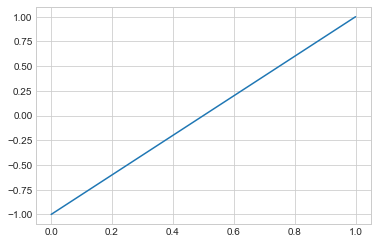

In [425]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

f = linear

x = np.linspace(0, 1, 1000)
plt.plot(x, f(x));

In [426]:
import numpy as np
from scipy.sparse import csr_matrix
A = csr_matrix([[1, 2, 0], [0, 0, 3], [4, 0, 5]])
v = np.array([1, 0, -1])
A.dot(v)

array([ 1, -3, -1])

In [525]:
from scipy.sparse import rand

pre_neuronal_states = csr_matrix(1* (np.random.rand(10,1)>.5))
post_neuronal_states = csr_matrix(1* (np.random.rand(10,1)>.5))
x = rand(10, 10, density=0.2, format='csr')
x.data[:] = 1


In [574]:
pre_neuronal_states.dot(post_neuronal_states.T)

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [589]:
(post_neuronal_states*2).todense()

matrix([[0],
        [0],
        [0],
        [0],
        [2],
        [2],
        [0],
        [0],
        [0],
        [0]])

In [594]:
class Thing:
    @classmethod
    @np.vectorize
    def linear(cls, x):
        return x*.4
    
Thing.linear(np.array([[4,2],[3,4]]))   

array([[1.6, 0.8],
       [1.2, 1.6]])

In [597]:
np.array([0,1]) < np.array([1,2]) < np.array([3,4])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [808]:
np.random.exponential(0.2,[4,1])

array([[0.29217379],
       [0.13400236],
       [0.23678195],
       [0.13140141]])